In [11]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
## 读取数据查看格式
train_data = pd.read_csv("../data/train.csv")
test_data = pd.read_csv("../data/train.csv")


train_data.info(),test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

(None, None)

In [12]:
##去除na值
train_data.dropna(axis=0, subset=['SalePrice'], inplace=True)

Y_train = train_data.SalePrice
final_idx = test_data.Id

## 开始找出训练数据中的缺失值列
cols_with_missing = [col for col in train_data.columns
                     if train_data[col].isnull().any()]

## 划分数据
## 1 需要的X_train
candidate_train_predictors = train_data.drop(['Id','SalePrice']+cols_with_missing,axis=1)
## 2 需要的X_test
candidate_test_predictors = test_data.drop(['Id']+cols_with_missing,axis=1)
## 寻找特殊的：类别变量，用于转换成热编码
low_cardinality_cols = [cname for cname in candidate_train_predictors.columns
                       if candidate_train_predictors[cname].nunique()<10
                       and candidate_train_predictors[cname].dtype == 'object']
## 寻找数值型变量
numeric_cols = [cname for cname in candidate_train_predictors.columns
                       if candidate_train_predictors[cname].dtype in ['int64','float64']]
## 重新排列，便于后续热编码
mycols = low_cardinality_cols+numeric_cols
train_predictors = candidate_train_predictors[mycols]
test_predictors = candidate_test_predictors[mycols]
print(len(train_predictors),len(test_predictors))

1460 1460


In [13]:
## 热编码一行代码搞定
X = pd.get_dummies(train_predictors)
final = pd.get_dummies(test_predictors)


print("Train features: "+str(len(X.columns)))
print("Test features: "+str(len(final.columns)))



# ## 两边热编码后，需要同步，类似于join，让两边数据类型保持一致
final_train, final_test = X.align(final,join='left',axis=1)

Train features: 159
Test features: 159


In [14]:
## 或者采取这种方式，这样的方式缺失值较少
# combined_data = pd.concat([final_train, final_test])
# one_hot_data = pd.get_dummies(combined_data)
# final_train = one_hot_data[:len(train_predictors)]
# final_test = one_hot_data[len(train_predictors):]
print(len(final_train.columns),len(final_test.columns))

159 159


In [15]:
## 两边join之后存在太多的缺失值 使用多变量缺失值填补来进行插值
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imp = IterativeImputer(max_iter=10, random_state=0)  ## 构建缺失值填补器
imp.fit(final_train) ## 对缺失值填补器进行训练
final_test = imp.transform(final_test) ## 对缺失值进行预测

In [16]:
from sklearn.ensemble import RandomForestRegressor
## 因为test数据集上没有Y的数据，为了评估模型效果，这里将train数据再拆分
from sklearn.model_selection import train_test_split
rfc = RandomForestRegressor(200)
X_train,X_test,Y_train,Y_test = train_test_split(final_train,Y_train,test_size=0.3)
print(Y_test)

168     183500
615     137500
239     113000
1252    130000
209     145000
         ...  
1138    196000
157     269500
1265    183900
554     284000
14      157000
Name: SalePrice, Length: 438, dtype: int64


In [17]:
rfc = rfc.fit(X_train,Y_train)
scores = rfc.score(X_test,Y_test)
print(scores)

0.8913970840581145


In [18]:
predict = rfc.predict(X_test)

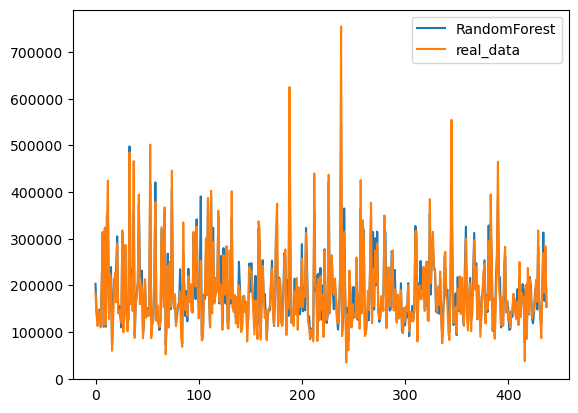

In [19]:
## baseline与真实数据图比较
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
real_data = np.array(Y_test)
# print(real_data)
plt.plot(predict,label = "RandomForest")
plt.plot(real_data,label = "real_data")
plt.legend()
plt.show()

In [21]:
## 最后对真实数据集进行预测
predict_true = rfc.predict(final_test)
commitee = pd.DataFrame({'Id':final_idx,'SalePrice':predict_true})
commitee
commitee.to_csv('../output/submisson.csv',index=None)